## Object Detection with Faster R-CNN

Fast R-CNN is a method for object detection that uses region proposal. In this lab, you will use Faster R-CNN pre-trained on the coco dataset. You will learn to detect several objects by name and to use the likelihood of the object prediction being correct.




In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

--2025-12-20 16:06:04--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48572 (47K) [image/jpeg]
Saving to: ‘DLguys.jpeg’

DLguys.jpeg         100%[===================>]  47.43K  --.-KB/s    in 0.04s   

2025-12-20 16:06:05 (1.13 MB/s) - ‘DLguys.jpeg’ saved [48572/48572]

--2025-12-20 16:06:05--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Resolving cf-courses-data.s3.us.cloud-objec

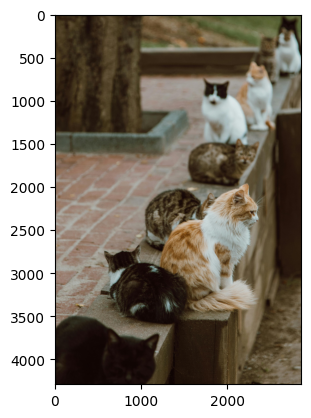

In [2]:
# GET EXAMPLES FROM PEXELS
# USE PYTHON TO GET IMAGES FROM PEXELS
from kaggle_secrets import UserSecretsClient
import requests
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def get_image_from_pexels(id_img: str, plot_img: bool = True):

    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("PEXELS-TOKEN")
    
    url = f"https://api.pexels.com/v1/photos/{id_img}"
    headers = {
        "Authorization": secret_value_0
    }
    
    response = requests.get(url, headers=headers)
    response_get_image = requests.get(response.json()['src']['original'])
    img = Image.open(BytesIO(response_get_image.content))
    
    if plot_img:
        plt.imshow(img)
    return img


test = get_image_from_pexels(id_img="6332001")

In [3]:
import torchvision
from torchvision import transforms
import torch
from torch import no_grad

In [4]:
import requests

In [5]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood is under a thereshold

In [6]:
from typing import List

def get_predictions(
        pred,
        coco_instance_category_names: list,
        threshold: float =.8,
        objects: None | List = None) -> List:
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """
    zip_list_pred = zip(
        list(
            pred[0]['labels'].numpy()),
            pred[0]['scores'].detach().numpy(),
            list(pred[0]['boxes'].detach().numpy()
            )
    )
    predicted_classes: list = [
        (
            coco_instance_category_names[i], p, [
                (
                    box[0],
                    box[1]
                ),
                (
                    box[2],
                    box[3]
                )
            ]
        ) for i, p, box in zip_list_pred 
    ]

    predicted_classes_stuff: list = [stuff for stuff in predicted_classes if stuff[1] > threshold]

    if objects and predicted_classes_stuff:
        return [
            (name, p, box) for name, p, box in predicted_classes_stuff if name in objects
        ]
    return predicted_classes_stuff


In [7]:
def draw_box(
        predicted_classes,
        image,
        rect_th: int = 10,
        text_size: int  = 3,
        text_th: int = 3) -> None:
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img = (
        np.clip(
            cv2.cvtColor(
                np.clip(
                    image.numpy().transpose((1, 2, 0)), 0, 1
                ),
                cv2.COLOR_RGB2BGR), 0, 1
            )*255
        ).astype(np.uint8).copy()

    for predicted_class in predicted_classes:

        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]
        t1 = box[0]
        b1, b2 = round(t1[0]), round(t1[1])
        t2 = box[1]
        c1, c2 = round(t2[0]), round(t2[1])

        cv2.rectangle(
            img, (b1, b2), (c1, c2), (0, 255, 0), 10
        )
        cv2.putText(
            img,
            label,
            (b1, b2),
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0, 255, 0),
            thickness=text_th
        )
        cv2.putText(
            img,
            label+": "+str(round(probability, 2)),
            (b1, b2),
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0,255,0),
            thickness=text_th
        )
    plt.figure(figsize=(30, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.axis("off")
    plt.show()
    del(img)
    del(image)

In [8]:
# def save_RAM(image_=False):
#     global image, img, pred
#     torch.cuda.empty_cache()
#     del(img)
#     del(pred)
#     if image_:
#         image.close()
#         del(image)

# Load Pre-trained Faster R-CNN

Faster R-CNN is a model that predicts both bounding boxes and class scores for potencial objetcs in the image pre-trained on COCO



In [9]:
T1_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)
T1_model.eval()


for name, param in T1_model.named_parameters():
    param.requires_grad = False

print('Done')


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 56.5MB/s]


Done


In [10]:
def model(x):
    with torch.no_grad():
        yhat = T1_model(x)
    return yhat

In [11]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__',
    'person',
    'bicycle',
    'car',
    'motorcycle', 
    'airplane', 
    'bus',
    'train',
    'truck',
    'boat', 
    'traffic light',
    'fire hydrant',
    'N/A',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog', 
    'horse', 
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'N/A', 
    'backpack', 
    'umbrella', 
    'N/A', 
    'N/A',
    'handbag',
    'tie',
    'suitcase', 
    'frisbee', 
    'skis', 
    'snowboard', 
    'sports ball',
    'kite', 
    'baseball bat',
    'baseball glove', 
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'N/A',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana', 
    'apple',
    'sandwich',
    'orange',
    'broccoli', 
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair', 
    'couch',
    'potted plant',
    'bed',
    'N/A',
    'dining table',
    'N/A',
    'N/A',
    'toilet',
    'N/A',
    'tv', 
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink', 'refrigerator', 'N/A', 'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear', 
    'hair drier',
    'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

# Object Localization

In Object Localization we locate the presence of object in an image indicate the locais with a bounding box. Consider the image of Geoffrey Hinto

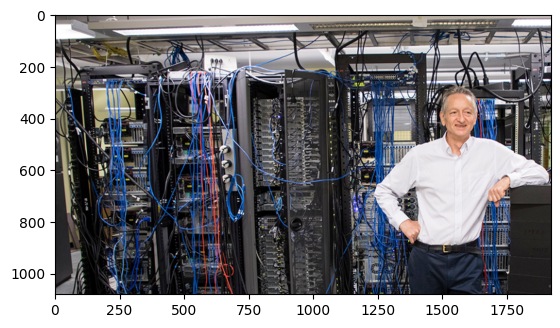

In [12]:
img_path: str = "jeff_hinton.png"
half: float = .5
image = Image.open(img_path)
image.resize(
    [
        int(half * s) for s in image.size
    ]
)

plt.imshow(image)
plt.show()

In [13]:
# We illl create a transform object to convert the image to a tensor

transform = transforms.Compose(
    [transforms.ToTensor()]
)



In [14]:
img = transform(image)
print(type(img))
print(img.shape)

<class 'torch.Tensor'>
torch.Size([3, 1080, 1920])


In [15]:
pred = model([img])
print(type(pred))
print(pred)

<class 'list'>
[{'boxes': tensor([[1223.1688,  301.2499, 1909.1726, 1076.6372],
        [1083.4658,  139.6489, 1413.0601,  355.5671],
        [1737.6132,  356.4109, 1763.9060,  396.9152],
        [ 248.0847,  230.1914,  671.7823, 1033.0297],
        [ 581.8290,  190.3602,  694.4933, 1049.6552],
        [1653.0668,  329.0836, 1700.3866,  481.7519],
        [1433.5494,  272.1133, 1605.0472,  497.6441],
        [1411.8370,  272.9348, 1541.3595,  503.5102],
        [ 106.5353,   81.2254, 1375.0603,  254.9701],
        [1713.5452,  350.7826, 1768.5363,  404.4330],
        [   0.0000,  344.7970,   69.7531, 1064.0659],
        [1627.0776,  328.4587, 1668.2725,  480.6585],
        [ 524.8185,  197.1050,  659.7603,  965.6730],
        [1730.2898,  350.3944, 1777.8383,  534.4158],
        [ 154.6211,  258.5715,  372.4108, 1014.8690],
        [ 617.3351,  151.1408,  737.8684, 1060.4773],
        [1100.5645,   95.3071, 1877.9144,  370.8577],
        [  28.8417,  175.5077,  456.2802,  252.7471],
  

In [16]:
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

In [17]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1767, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

In [18]:
idx = pred[0]['labels'][0].item()
print(COCO_INSTANCE_CATEGORY_NAMES[idx])


person


In [19]:
# Bounding_box
bbox = pred[0]['boxes'][0].tolist()
bbox

[1223.1688232421875, 301.24993896484375, 1909.172607421875, 1076.63720703125]

In [20]:
t, l, r, b = [round(x) for x in bbox]
t, l, r, b

(1223, 301, 1909, 1077)

We convert the tensor to an open CV array and plot an image with the box:


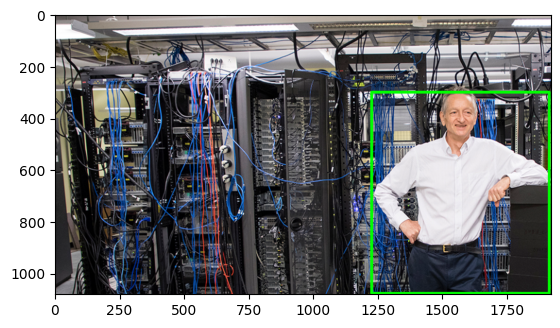

In [21]:
img_plot = (
    np
    .clip(
        cv2
        .cvtColor(
            np
            .clip(
                img
                .numpy()
                .transpose(
                    (1, 2, 0)
                ),0,1),
                cv2.COLOR_RGB2BGR
                ),0,1)*255).astype(np.uint8)

cv2.rectangle(
    img_plot, (t, l), (r, b), (0, 255, 0), 10
)

plt.imshow(cv2.cvtColor(
    img_plot,
    cv2.COLOR_BGR2RGB
))
plt.show()
del img_plot, t, l, r, b

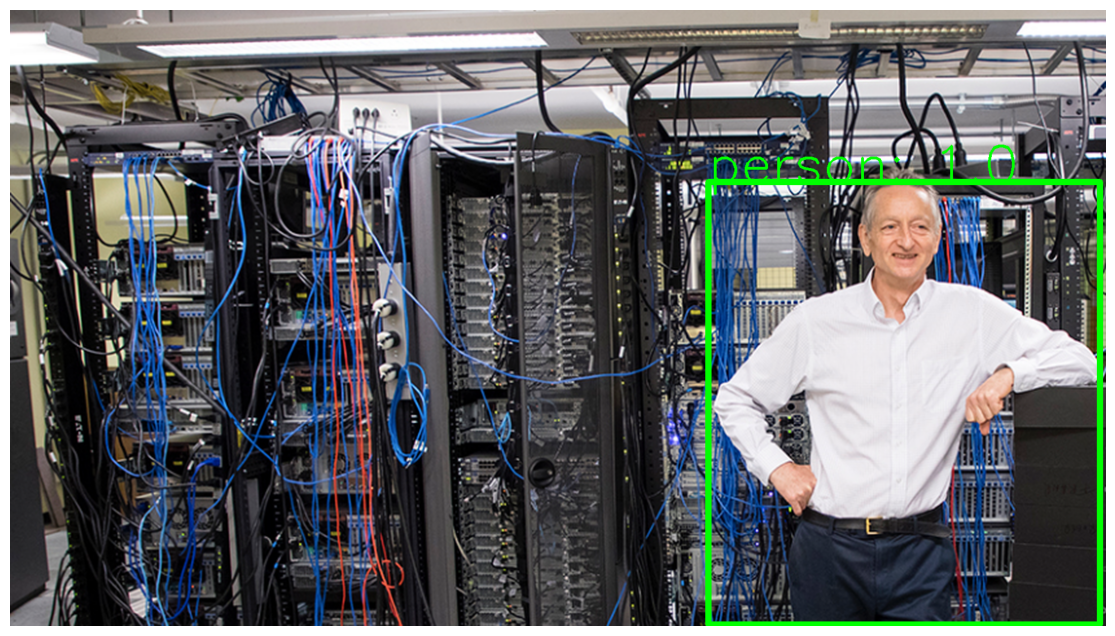

In [22]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class, image=img
)
del pred_class


In [23]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=0.1
)
pred_class

[('person',
  np.float32(0.999546),
  [(np.float32(1223.1688), np.float32(301.24994)),
   (np.float32(1909.1726), np.float32(1076.6372))])]

In [24]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=0.3
)
pred_class

[('person',
  np.float32(0.999546),
  [(np.float32(1223.1688), np.float32(301.24994)),
   (np.float32(1909.1726), np.float32(1076.6372))])]

In [25]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=0.5
)
pred_class

[('person',
  np.float32(0.999546),
  [(np.float32(1223.1688), np.float32(301.24994)),
   (np.float32(1909.1726), np.float32(1076.6372))])]

In [26]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=1
)
pred_class

[]

In [27]:
def analytic_detection(id_img: str):

    image = get_image_from_pexels(id_img=id_img, plot_img=False)
    image.resize([int(half * s) for s in image.size])
    
    img = transform(image)
    print(type(img))
    print(img.shape)
    
    pred = model([img])
    print(type(pred))
    
    pred_class = get_predictions(
        pred=pred,
        threshold=.8,
        coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
    )
    
    print('-'*30)
    print('Get')
    print(pred_class)
    print(f'Total Objects{len(pred_class)}')
    import pandas as pd
    df = pd.DataFrame(pred_class, columns=['class', 'score', 'bbox'])
    print(df.shape)
    print(df.head())
    print(df['class'].value_counts())
    print('-'*30)
    
    draw_box(
        predicted_classes=pred_class,
        image=img,
        rect_th=1,
        text_size=1,
        text_th=1
    )
    del pred_class


<class 'torch.Tensor'>
torch.Size([3, 4288, 2859])
<class 'list'>
------------------------------
Get
[('cat', np.float32(0.99753654), [(np.float32(1132.3674), np.float32(1981.2246)), (np.float32(2378.0771), np.float32(3531.0803))]), ('cat', np.float32(0.99723876), [(np.float32(1694.6283), np.float32(741.79156)), (np.float32(2233.4165), np.float32(1514.3243))]), ('cat', np.float32(0.9971163), [(np.float32(565.786), np.float32(2672.8728)), (np.float32(1551.0409), np.float32(3562.8655))]), ('cat', np.float32(0.987982), [(np.float32(1539.4756), np.float32(1448.0133)), (np.float32(2347.3032), np.float32(1971.5631))]), ('cat', np.float32(0.9872435), [(np.float32(0.0), np.float32(3525.232)), (np.float32(1208.421), np.float32(4273.759))]), ('cat', np.float32(0.9868651), [(np.float32(1029.1783), np.float32(2018.6583)), (np.float32(1754.8721), np.float32(2724.5999))]), ('cat', np.float32(0.8948467), [(np.float32(2175.881), np.float32(490.6614)), (np.float32(2535.3008), np.float32(1326.0542))])]


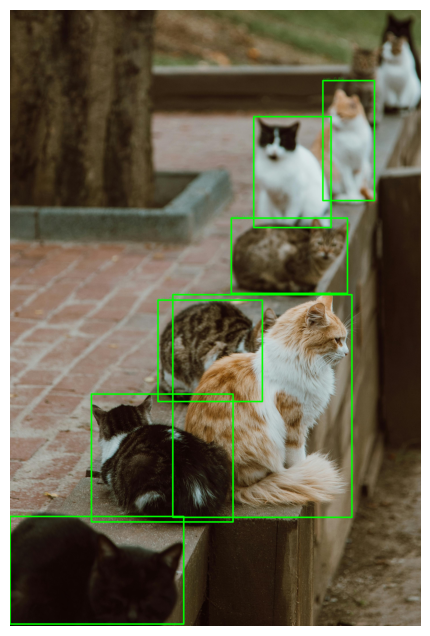

In [28]:
analytic_detection(id_img="6332001")

<class 'torch.Tensor'>
torch.Size([3, 4624, 3472])
<class 'list'>
------------------------------
Get
[('person', np.float32(0.9959974), [(np.float32(1964.5951), np.float32(2559.7095)), (np.float32(2205.085), np.float32(3267.6318))]), ('person', np.float32(0.9955485), [(np.float32(1318.8984), np.float32(3269.9272)), (np.float32(2127.9917), np.float32(4590.576))]), ('chair', np.float32(0.98929334), [(np.float32(196.25774), np.float32(3252.5754)), (np.float32(630.93353), np.float32(4020.592))]), ('chair', np.float32(0.9876867), [(np.float32(530.49677), np.float32(3391.859)), (np.float32(1099.3966), np.float32(4184.174))]), ('person', np.float32(0.9874599), [(np.float32(1681.7561), np.float32(2467.898)), (np.float32(1863.0614), np.float32(3223.1648))]), ('person', np.float32(0.98325306), [(np.float32(1452.1816), np.float32(2411.9915)), (np.float32(1592.8129), np.float32(2795.0986))]), ('person', np.float32(0.9781473), [(np.float32(2326.8105), np.float32(3155.8809)), (np.float32(3194.3577),

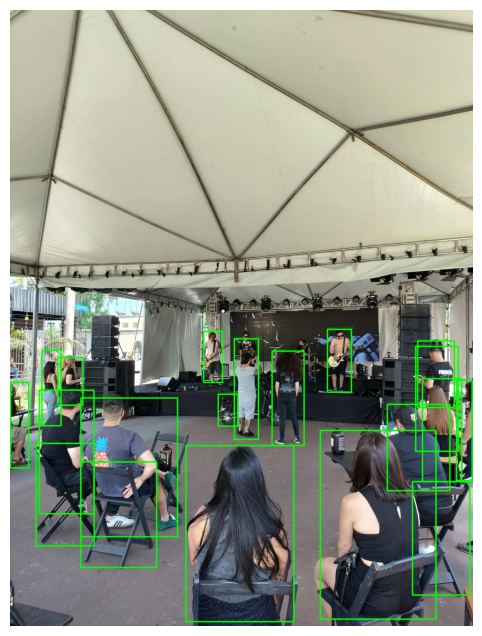

In [29]:
analytic_detection(id_img="35120241")

<class 'torch.Tensor'>
torch.Size([3, 3241, 4861])
<class 'list'>
------------------------------
Get
[('person', np.float32(0.99865985), [(np.float32(4194.893), np.float32(2008.8948)), (np.float32(4554.141), np.float32(2920.3035))]), ('person', np.float32(0.9978637), [(np.float32(3430.9204), np.float32(2105.588)), (np.float32(3723.5388), np.float32(2833.459))]), ('person', np.float32(0.9976646), [(np.float32(197.85646), np.float32(2044.2236)), (np.float32(532.6557), np.float32(2758.5117))]), ('person', np.float32(0.9942174), [(np.float32(4.4566493), np.float32(2346.8376)), (np.float32(234.12552), np.float32(2797.4053))]), ('person', np.float32(0.9937907), [(np.float32(1772.8268), np.float32(2039.5396)), (np.float32(1980.2681), np.float32(2528.8481))]), ('person', np.float32(0.9932853), [(np.float32(3903.362), np.float32(2038.0922)), (np.float32(4157.3335), np.float32(2908.2297))]), ('person', np.float32(0.9910602), [(np.float32(3724.3665), np.float32(2113.3418)), (np.float32(3925.2786)

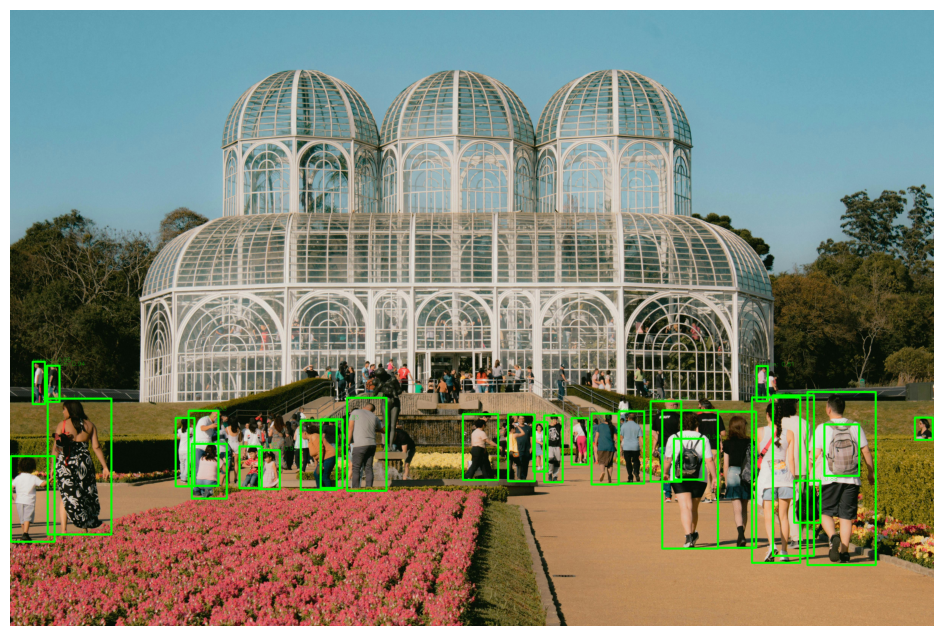

In [30]:
analytic_detection(id_img="18641612")

<class 'torch.Tensor'>
torch.Size([3, 2268, 3024])
<class 'list'>
------------------------------
Get
[('person', np.float32(0.99671304), [(np.float32(1654.1237), np.float32(1445.9358)), (np.float32(1953.2546), np.float32(2266.9338))]), ('person', np.float32(0.99565446), [(np.float32(2012.8363), np.float32(1577.784)), (np.float32(2308.2766), np.float32(2259.4238))]), ('person', np.float32(0.99558866), [(np.float32(1.4165685), np.float32(1426.7312)), (np.float32(725.0656), np.float32(2255.3113))]), ('person', np.float32(0.99464333), [(np.float32(1191.841), np.float32(1448.815)), (np.float32(1426.905), np.float32(2229.264))]), ('person', np.float32(0.99119204), [(np.float32(1904.8105), np.float32(1450.8652)), (np.float32(2109.6296), np.float32(2224.783))]), ('person', np.float32(0.99017614), [(np.float32(1488.4578), np.float32(1447.3243)), (np.float32(1717.4845), np.float32(2260.964))]), ('person', np.float32(0.9828997), [(np.float32(643.0013), np.float32(1374.0574)), (np.float32(803.9091

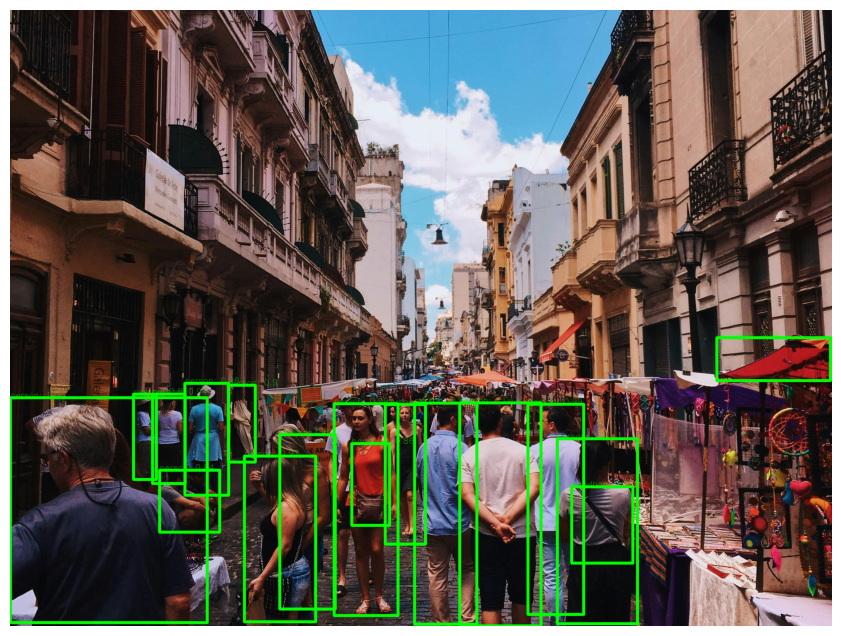

In [31]:
analytic_detection(id_img="1060803")

<class 'torch.Tensor'>
torch.Size([3, 2635, 4288])
<class 'list'>
------------------------------
Get
[('car', np.float32(0.99688786), [(np.float32(472.63116), np.float32(2257.848)), (np.float32(887.4595), np.float32(2560.251))]), ('car', np.float32(0.9949103), [(np.float32(1077.9036), np.float32(2166.5015)), (np.float32(1424.4575), np.float32(2432.9893))]), ('car', np.float32(0.9918572), [(np.float32(956.5791), np.float32(2022.2147)), (np.float32(1249.7443), np.float32(2231.6875))]), ('car', np.float32(0.9851893), [(np.float32(2741.353), np.float32(1990.8071)), (np.float32(2974.547), np.float32(2220.6338))]), ('car', np.float32(0.9807098), [(np.float32(3723.2756), np.float32(1720.2832)), (np.float32(3975.1362), np.float32(1888.6174))]), ('car', np.float32(0.9753237), [(np.float32(426.60944), np.float32(1685.522)), (np.float32(733.7718), np.float32(1862.3881))]), ('car', np.float32(0.96760654), [(np.float32(17.985807), np.float32(1770.259)), (np.float32(317.86652), np.float32(1948.101))

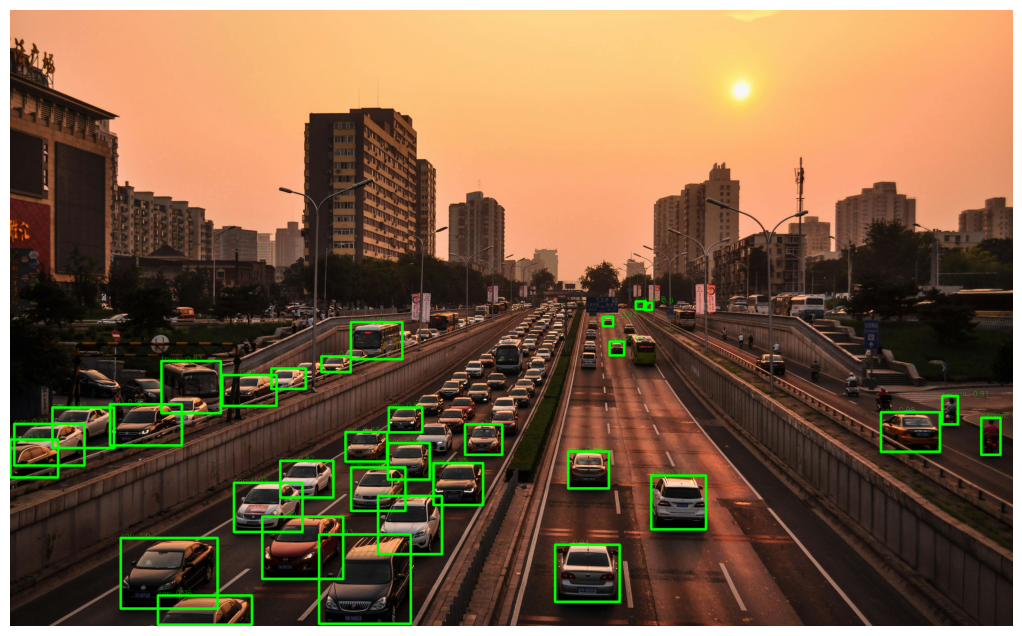

In [32]:
analytic_detection(id_img="210182")